<a href="https://colab.research.google.com/github/theostoican/MastersThesis/blob/main/Investigation_Escaping_local_minima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable

# Models

A dummy network that receives as input the precomputed incoming and outgoing weights and sets them directly.

In [23]:
torch.set_default_dtype(torch.float64)
class DummyNetwork(nn.Module):
  def __init__(self, D_in, H, D_out, w_in, w_out):
    """
    In the constructor we instantiate two nn.Linear modules and assign them as
    member variables.

    D_in: input dimension
    H: dimension of hidden layer
    D_out: output dimension of the first layer
    """
    super(DummyNetwork, self).__init__()
    self.linear1 = nn.Linear(D_in, H, bias=False)
    self.linear2 = nn.Linear(H, D_out, bias=False)
    self.linear1.weight = torch.nn.Parameter(w_in)
    self.linear2.weight = torch.nn.Parameter(w_out)
  def forward(self, x):
    """
    In the forward function we accept a Variable of input data and we must
    return a Variable of output data. We can use Modules defined in the
    constructor as well as arbitrary operators on Variables.
    """
    h_sigmoid = torch.sigmoid(self.linear1(x))
    y_pred = self.linear2(h_sigmoid)
    return y_pred

In [24]:
class TeacherNetwork(nn.Module):
  def __init__(self, D_in, H, D_out):
    """
    In the constructor we instantiate two nn.Linear modules and assign them as
    member variables.

    D_in: input dimension
    H: dimension of hidden layer
    D_out: output dimension of the first layer
    """
    super(TeacherNetwork, self).__init__()
    self.linear1 = nn.Linear(D_in, H, bias=False)
    self.linear2 = nn.Linear(H, D_out, bias=False)
    self.linear1.weight = torch.nn.Parameter(torch.transpose(torch.DoubleTensor([[0.6, -0.5, -0.2, 0.1], [0.5, 0.5, -0.6, -0.6]]), 0, 1))
    self.linear2.weight = torch.nn.Parameter(torch.transpose(torch.DoubleTensor([[1], [-1], [1], [-1]]), 0, 1))
  def forward(self, x):
    """
    In the forward function we accept a Variable of input data and we must
    return a Variable of output data. We can use Modules defined in the
    constructor as well as arbitrary operators on Variables.
    """
    h_sigmoid = torch.sigmoid(self.linear1(x))
    y_pred = self.linear2(h_sigmoid)
    return y_pred

# Dataset

In [25]:
D_in, H_teacher, H_student, D_out = 2, 4, 5, 1

def construct_dataset():
  data = []
  for y in np.arange(-5, 5.1, .25):
    for x in np.arange(-5, 5.1, .25):
      data.append([x, y])
  return data

dataset = torch.DoubleTensor(construct_dataset()) 
print(len(construct_dataset()))

1681


# Labels

In [26]:
teacher_model = TeacherNetwork(D_in, H_teacher, D_out)
y_labels = teacher_model(dataset).detach()

In [27]:
data = pd.read_csv('fixed_points.csv', float_precision='round_trip')
data = data[data['loss'] >= 1e-6]
len(data)

434

In [28]:
# 607 is the initial point that we tried on
sample_point = data.sample()
for _, sample_point in sample_point.iterrows():
  pass
print(sample_point['gradient_norm'])
print(sample_point['loss'])

5.573153343920587e-10
8.924282994667899e-05


### Helper for extracting the weights from one data point.

In [29]:
def extract_weights(data_point):
  incoming_weights_x = [data_point['w11'],
                      data_point['w21'],
                      data_point['w31'],
                      data_point['w41'],
                      data_point['w51']]
  incoming_weights_y = [data_point['w12'],
                      data_point['w22'],
                      data_point['w32'],
                      data_point['w42'],
                      data_point['w52']]
  outgoing_weights = [data_point['a1'],
                    data_point['a2'],
                    data_point['a3'],
                    data_point['a4'],
                    data_point['a5']]
  return incoming_weights_x, incoming_weights_y, outgoing_weights

In [30]:
incoming_weights_x, incoming_weights_y, outgoing_weights = extract_weights(sample_point)
print(incoming_weights_x)
print(incoming_weights_y)
print(outgoing_weights)

[1.3824944844608913, 1.3532366696310842, -0.024173078372403133, -1.3580737078446679, -1.3723039617335706]
[-0.9204062446653644, 0.7461294056231709, 0.00271824282641098, 0.9076079665308346, -0.753520711861038]
[-9.360420051688832, 12.4411689164707, -5.358332095383467, -9.731771589482358, 12.009354819685788]


# Helper for computing the norm of the gradient.

In [31]:
def eval_grad_norm(loss_grad, model):
  cnt = 0
  for g in loss_grad:
      g_vector = g.contiguous().view(-1) if cnt == 0 else torch.cat([g_vector, g.contiguous().view(-1)])
      cnt = 1
  grad_norm = torch.norm(g_vector)
  return grad_norm.detach().numpy()

## Smallest eigenvalue using JAX

In [32]:
import jax.numpy as jnp
from jax import nn as jax_nn
from jax.config import config; config.update("jax_enable_x64", True)
jnp.set_printoptions(precision=32) 

jnp_inputs = jnp.array(construct_dataset(), dtype=jnp.float64)
jnp_labels = jnp.array(teacher_model(dataset).detach(), dtype=jnp.float64)

def predict(w_in, w_out):
  return w_out @ jnp.transpose(jax_nn.sigmoid(jnp_inputs @ jnp.transpose(w_in)))

w_in = jnp.array([[incoming_weights_x[0], incoming_weights_y[0]],
                  [incoming_weights_x[1], incoming_weights_y[1]],
                  [incoming_weights_x[2], incoming_weights_y[2]],
                  [incoming_weights_x[3], incoming_weights_y[3]],
                  [incoming_weights_x[4], incoming_weights_y[4]]], dtype=jnp.float64)
w_out = jnp.array(outgoing_weights, dtype=jnp.float64)

### Loss in JAX

Loss of the network computed in JAX.

In [33]:
def loss(w):
  w_in = w[0 : 2 * H_student].reshape(D_in, H_student).T
  w_out = w[2 * H_student : ].reshape(1, H_student)
  preds = predict(w_in, w_out).T
  return jnp.mean(jnp.mean(jnp.square(preds - jnp_labels)))
print(loss(jnp.append(w_in.T.reshape(D_in * H_student), w_out.reshape(H_student))))

8.924282994668348e-05


### Hessian in JAX

In [34]:
from jax import jacfwd, jacrev, grad
import jax

def hessian(f):
  return jacfwd(jacrev(f))

H = hessian(loss)(jnp.append(w_in.T.reshape(D_in * H_student), w_out.reshape(H_student)))

### Eigenvalues in JAX

In [35]:
evals, evectors = jnp.linalg.eig(H)

# Sanity check
for eval in jnp.array([jax.lax.imag(eval) for eval in evals]):
  assert eval == 0

evals = jnp.array([jax.lax.real(eval) for eval in evals])
print(evals)
smallest_evector = jnp.array([jax.lax.real(elem) for elem in evectors[:, jnp.argmin(evals)]])
print(smallest_evector)

[1.0462108888579104e+02 7.5169223226197474e+01 1.6944534661100864e+01
 5.5670925353244822e+00 3.2564819971167371e+00 1.6532881307396046e+00
 2.4999918707725994e+00 2.5394666106869912e-02 2.0173960126650178e-02
 1.1113930398703165e-03 9.3199237898946641e-04 3.9741943854077352e-05
 3.1799202812637817e-05 3.9319073648703123e-11 1.1144393644694507e-10]
[-6.3494416618268819e-04  3.8208032271410200e-04  5.5148851152514455e-04
 -5.5478768565038646e-04  4.3813649407896437e-04  3.5354766838903098e-04
  1.3251894314291439e-04 -6.2063557875356457e-05  2.7027111441955666e-04
  1.8563757290058399e-04 -4.6498130384614433e-01  5.2574620306674102e-01
 -1.2150098037973435e-01 -4.6499787773378637e-01  5.2573395891399344e-01]


## Perturbation (based on JAX evectors)

In [36]:
old_loss = loss(jnp.append(w_in.T.reshape(D_in * H_student), w_out.reshape(H_student)))

perturb_lower_bound = -4.0
perturb_upper_bound = 4.0
perturb_step = 0.01

perturb_losses = []
perturb_evals = []
perturb_grads = []

weights = jnp.append(w_in.T.reshape(D_in * H_student), w_out.reshape(H_student))
for eps in np.arange(perturb_lower_bound, perturb_upper_bound, perturb_step):
  new_weights = weights + eps * smallest_evector
  # print(new_weights[0 : D_in * H_student].reshape(D_in, H_student).T)
  # w_in = torch.DoubleTensor(new_weights[0 : D_in * H_student].reshape(D_in, H_student).T)
  # w_out = torch.DoubleTensor([new_weights[D_in * H_student:]])
  # dummy_model = DummyNetwork(D_in, H_student, D_out, w_in, w_out)
  # loss_grad = torch.autograd.grad(nn.MSELoss()(dummy_model(dataset),
  #                                              y_labels),
  #                                 dummy_model.parameters(),
  #                                 create_graph=True)
  sign = 1 if eps > 0 else -1
  # perturb_grads.append(jnp.dot(grad(loss)(new_weights), sign * smallest_evector))
  perturb_grads.append(jnp.linalg.norm(grad(loss)(new_weights)))
  
  H = hessian(loss)(new_weights)
  H = (H + H.T) / 2
  evals, _ = jnp.linalg.eig(H)

  perturb_evals.append(min(evals))
  perturb_losses.append(loss(new_weights))

Check the smallest eigenvectors at perturbation factor \in {-1, 1}.

In [37]:
new_weights = weights - 0.4 * smallest_evector
H = hessian(loss)(new_weights)
H = (H + H.T) / 2
evals, evectors = jnp.linalg.eig(H)
# Sanity check
for eval in jnp.array([jax.lax.imag(eval) for eval in evals]):
  assert eval == 0

evals = jnp.array([jax.lax.real(eval) for eval in evals])
smallest_evector_left = jnp.array([jax.lax.real(elem) for elem in evectors[:, jnp.argmin(evals)]])
smallest_evector_left

DeviceArray([ 1.9442630698122002e-05, -8.1273888616808320e-06,
              4.1235068508277666e-03,  4.6818794982335328e-04,
              4.3269693062534566e-04,  1.6344123536621017e-04,
             -1.5067453015625443e-04, -4.6311093949397093e-04,
             -4.1601999462071858e-04,  3.1767726832463946e-04,
              1.8278607873516164e-01,  2.6310262549265134e-01,
             -8.9152901923650973e-01,  1.8265379290182707e-01,
              2.6298651984231924e-01], dtype=float64)

In [38]:
new_weights = weights + 0.4 * smallest_evector
H = hessian(loss)(new_weights)
H = (H + H.T) / 2
evals, evectors = jnp.linalg.eig(H)
# Sanity check
for eval in jnp.array([jax.lax.imag(eval) for eval in evals]):
  assert eval == 0
print(min(evals))
evals = jnp.array([jax.lax.real(eval) for eval in evals])
print(min(evals))

smallest_evector_right = jnp.array([jax.lax.real(elem) for elem in evectors[:, jnp.argmin(evals)]])
print(min(evals))
smallest_evector_right

(-2.786852426819432e-09+0j)
-2.786852426819432e-09
-2.786852426819432e-09


DeviceArray([ 1.3796834509034627e-05, -1.5079632956933317e-05,
              3.9761728807604750e-03,  4.4084371983677152e-04,
              4.0938805452986202e-04,  1.5810510306579336e-04,
             -1.4696686398427052e-04, -4.4652959618638149e-04,
             -3.9362481400152631e-04,  3.0207159696204485e-04,
              1.8426205181495542e-01,  2.6172207808228953e-01,
             -8.9173186169698948e-01,  1.8413658809563399e-01,
              2.6161114154590898e-01], dtype=float64)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'smallest eval')

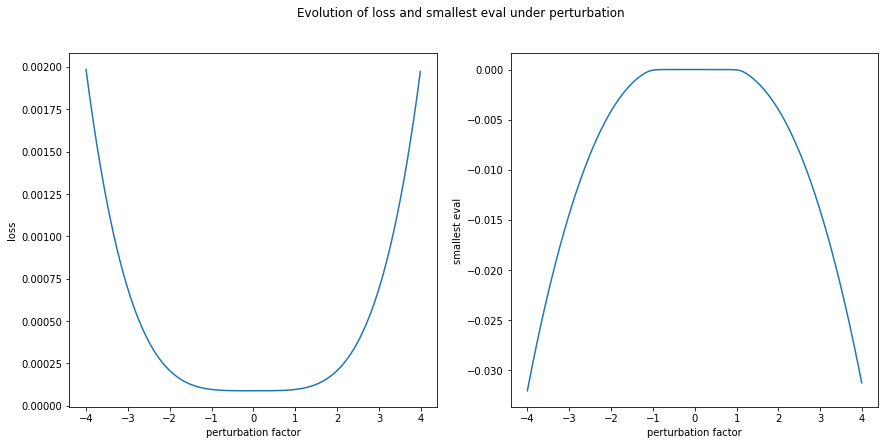

In [39]:
perturb_losses_new_smallest_evector = []
perturb_evals_new_smallest_evector = []

weights_new_smallest_evector = weights - 0.4 * smallest_evector
for eps in np.arange(perturb_lower_bound, perturb_upper_bound, perturb_step):
  new_weights = weights_new_smallest_evector + eps * smallest_evector_left
  
  H = hessian(loss)(new_weights)
  H = (H + H.T) / 2
  evals, _ = jnp.linalg.eig(H)

  perturb_evals_new_smallest_evector.append(min(evals))
  perturb_losses_new_smallest_evector.append(loss(new_weights))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(14.5, 6.5)
fig.suptitle('Evolution of loss and smallest eval under perturbation')
ax1.plot(np.arange(perturb_lower_bound, perturb_upper_bound, perturb_step), perturb_losses_new_smallest_evector)
ax1.ticklabel_format(useOffset=False)
ax1.set_xlabel('perturbation factor')
ax1.set_ylabel('loss')

ax2.plot(np.arange(perturb_lower_bound, perturb_upper_bound, perturb_step), perturb_evals_new_smallest_evector)
ax2.set_xlabel('perturbation factor')
ax2.set_ylabel('smallest eval')

In [40]:
def run_perturbation_algo(start_evector,
                          direction_evector,
                          start_weights,
                          perturb_losses,
                          perturb_norm_grads,
                          perturb_smallest_eval,
                          eps = 1e-4):
  current_weights = start_weights
  current_evector = direction_evector * start_evector

  perturb_losses.append(loss(current_weights))
  perturb_norm_grads.append(jnp.linalg.norm(grad(loss)(current_weights)))

  H = hessian(loss)(current_weights)
  H = (H + H.T) / 2
  evals, evectors = jnp.linalg.eig(H)
  evals = jnp.array([jax.lax.real(eval) for eval in evals])

  perturb_smallest_eval.append(jnp.min(evals))

  while True:
    current_weights = current_weights + eps * current_evector

    H = hessian(loss)(current_weights)
    H = (H + H.T) / 2
    evals, evectors = jnp.linalg.eig(H)
    evals = jnp.array([jax.lax.real(eval) for eval in evals])

    last_evector = current_evector
    current_evector = jnp.array([jax.lax.real(elem) for elem in evectors[:, jnp.argmin(evals)]])

    if jnp.linalg.norm(grad(loss)(current_weights)) >= 1e-9:
      break
    if abs(jnp.dot(direction_evector * current_evector, last_evector)) < 0.99:
      print(direction_evector, jnp.dot(direction_evector * current_evector, last_evector))
      run_perturbation_algo(current_evector, -direction_evector, current_weights, perturb_losses,
                            perturb_norm_grads, perturb_smallest_eval, eps)
    
    perturb_losses.append(loss(current_weights))
    perturb_norm_grads.append(jnp.linalg.norm(grad(loss)(current_weights)))
    perturb_smallest_eval.append(jnp.min(evals))

    current_evector *= direction_evector

  # last_evector = start_evector
  # while True:
  #   current_weights = current_weights + eps * current_evector
  #   # print(abs(jnp.dot(grad(loss)(current_weights), current_evector)))
  #   if jnp.linalg.norm(grad(loss)(current_weights)) >= 1e-9:
  #     break
    
  #   H = hessian(loss)(new_weights)
  #   H = (H + H.T) / 2
  #   evals, evectors = jnp.linalg.eig(H)
  #   evals = jnp.array([jax.lax.real(eval) for eval in evals])
  #   current_evector = jnp.array([jax.lax.real(elem) for elem in evectors[:, jnp.argmin(evals)]])
  #   print(jnp.dot(current_evector, last_evector))
  #   last_evector = current_evector

  #   perturb_losses.append(loss(current_weights))
  #   perturb_smallest_eval.append(jnp.min(evals))
  #   perturb_norm_grads.append(jnp.linalg.norm(grad(loss)(current_weights)))
  
  # return perturb_losses, perturb_norm_grads, perturb_smallest_eval, last_evector

dyn_perturb_losses = []
dyn_perturb_norm_grads = []
dyn_perturb_smallest_eval = []
run_perturbation_algo(smallest_evector, 1, weights, dyn_perturb_losses,
                      dyn_perturb_norm_grads, dyn_perturb_smallest_eval)
dyn_perturb_losses.reverse()
dyn_perturb_norm_grads.reverse()
dyn_perturb_smallest_eval.reverse()
run_perturbation_algo(smallest_evector, -1, weights, dyn_perturb_losses,
                      dyn_perturb_norm_grads, dyn_perturb_smallest_eval)
# dyn_perturb_losses, dyn_perturb_norm_grads, dyn_perturb_smallest_eval = run_perturbation_algo(smallest_evector, weights)

print(perturb_losses)
print(min(perturb_losses))

# dynamic_fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
# dynamic_fig.set_size_inches(20, 3.5)
# dynamic_fig.suptitle('Evolution of loss, smallest eval, and grad norm under perturbation')

# ax1.plot(np.arange(perturb_lower_bound, perturb_upper_bound, perturb_step), perturb_losses)
# ax1.ticklabel_format(useOffset=False)
# ax1.set_xlabel('perturbation factor')
# ax1.set_ylabel('loss')

# ax2.plot(np.arange(perturb_lower_bound, perturb_upper_bound, perturb_step), perturb_evals)
# ax2.set_xlabel('perturbation factor')
# ax2.set_ylabel('smallest eval')

# ax3.plot(np.arange(perturb_lower_bound, perturb_upper_bound, perturb_step), perturb_grads)
# ax3.set_xlabel('perturbation factor')
# ax3.set_ylabel('gradient norm')

[DeviceArray(9.006115569743815e-05, dtype=float64), DeviceArray(9.005301388705188e-05, dtype=float64), DeviceArray(9.004493302769586e-05, dtype=float64), DeviceArray(9.003691281431275e-05, dtype=float64), DeviceArray(9.002895294260952e-05, dtype=float64), DeviceArray(9.00210531090556e-05, dtype=float64), DeviceArray(9.001321301089242e-05, dtype=float64), DeviceArray(9.000543234611606e-05, dtype=float64), DeviceArray(8.999771081349635e-05, dtype=float64), DeviceArray(8.999004811256761e-05, dtype=float64), DeviceArray(8.998244394362395e-05, dtype=float64), DeviceArray(8.997489800772919e-05, dtype=float64), DeviceArray(8.9967410006712e-05, dtype=float64), DeviceArray(8.995997964316238e-05, dtype=float64), DeviceArray(8.995260662044186e-05, dtype=float64), DeviceArray(8.994529064266943e-05, dtype=float64), DeviceArray(8.993803141473682e-05, dtype=float64), DeviceArray(8.9930828642294e-05, dtype=float64), DeviceArray(8.992368203176052e-05, dtype=float64), DeviceArray(8.991659129032306e-05, 

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'gradient norm')

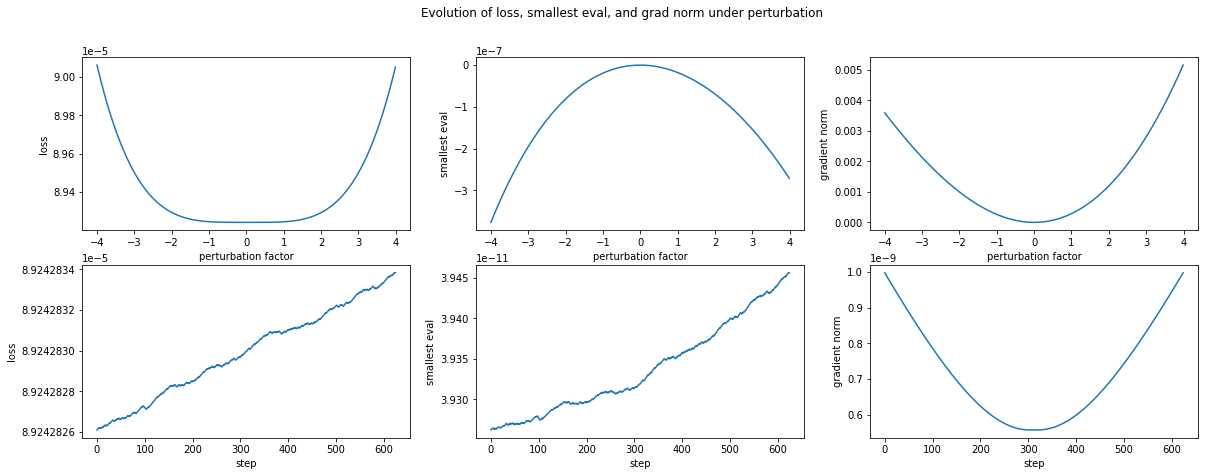

In [41]:
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(20, 7)
fig.suptitle('Evolution of loss, smallest eval, and grad norm under perturbation')

axs[0, 0].plot(np.arange(perturb_lower_bound, perturb_upper_bound, perturb_step), perturb_losses)
axs[0, 0].ticklabel_format(useOffset=False)
axs[0, 0].set_xlabel('perturbation factor')
axs[0, 0].set_ylabel('loss')

axs[0, 1].plot(np.arange(perturb_lower_bound, perturb_upper_bound, perturb_step), perturb_evals)
axs[0, 1].set_xlabel('perturbation factor')
axs[0, 1].set_ylabel('smallest eval')

axs[0, 2].plot(np.arange(perturb_lower_bound, perturb_upper_bound, perturb_step), perturb_grads)
axs[0, 2].set_xlabel('perturbation factor')
axs[0, 2].set_ylabel('gradient norm')

axs[1, 0].plot(np.arange(len(dyn_perturb_losses)), dyn_perturb_losses)
axs[1, 0].ticklabel_format(useOffset=False)
axs[1, 0].set_xlabel('step')
axs[1, 0].set_ylabel('loss')

axs[1, 1].plot(np.arange(len(dyn_perturb_smallest_eval)), dyn_perturb_smallest_eval)
axs[1, 1].set_xlabel('step')
axs[1, 1].set_ylabel('smallest eval')

axs[1, 2].plot(np.arange(len(dyn_perturb_norm_grads)), dyn_perturb_norm_grads)
axs[1, 2].set_xlabel('step')
axs[1, 2].set_ylabel('gradient norm')